# Table Development

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

# Define a macrospin mesh (i.e. one discretisation cell).
p1 = (0, 0, 0)  # first point of the mesh domain (m)
p2 = (1e-9, 1e-9, 1e-9)  # second point of the mesh domain (m)
n = (1, 1, 1)  # discretisation cell size (m)

Ms = 8e6  # magnetisation saturation (A/m)
H = (0, 0, 2e6)  # external magnetic field (A/m)
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.1  # Gilbert damping

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, n=n)

system = mm.System(name='macrospin')
system.energy = mm.Zeeman(H=H)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)
system.m = df.Field(mesh, dim=3, value=(1, 0, 0), norm=Ms)

td = mc.TimeDriver()
td.drive(system, t=0.1e-9, n=200)

Running OOMMF (DockerOOMMFRunner) [2021/08/17 17:36]... (5.8 s)


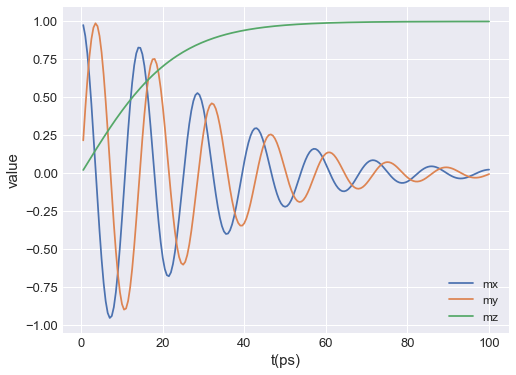

In [2]:
system.table.mpl(y=['mx', 'my', 'mz'])

In [3]:
import numpy as np
import ubermagtable as ut
import pandas as pd

In [4]:
def rfft(table, x=None, y=None):
    if x is None and table.x is not None:
            x = table.x
            
    if x not in table.data.columns:
            msg = f'Independent variable {x=} is not in table.'
            raise ValueError(msg)
    
    freqs = np.fft.rfftfreq(table.data[x].size, np.abs(table.data[x].iloc[1]-table.data[x].iloc[0]))
    cols = ['Frequency']
    units = {'Frequency':'Hz'}
    data = freqs

    if y is None:
            y = table.y
    
    for i in y:
        cols.append('ft_' + i)
        units['ft_' + i] = '(' + table.units[i] + ')^-1'
        data = np.column_stack([data, np.fft.rfft(table.data[i])])
    return ut.Table(pd.DataFrame(data, columns=cols), units, x=cols[0])

def irfft(table, x=None, y=None):
    if x is None and table.x is not None:
            x = table.x
            
    if x not in table.data.columns:
            msg = f'Independent variable {x=} is not in table.'
            raise ValueError(msg)
    
    t = 0 # TODO
    cols = ['t']
    units = {'t':'s'}
    data = t

    if y is None:
            y = table.y
    
    for i in y:
        cols.append(i[3:])
        units[i[3:]] = table.units[i][1:-4]
        data = np.column_stack([data, np.fft.irfft(table.data[i])])
    return ut.Table(pd.DataFrame(data, columns=cols), units, x=cols[0])

In [5]:
new_table = rfft(system.table, y=['mx', 'my', 'mz'])

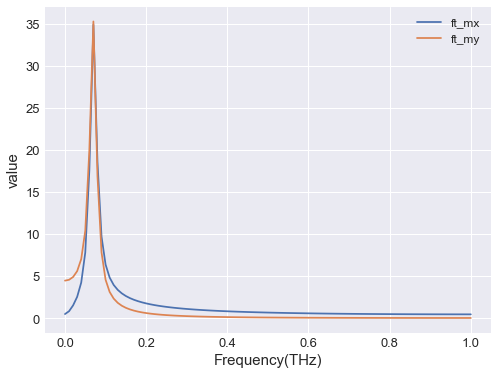

In [6]:
new_table.abs.mpl(y=['ft_mx', 'ft_my'])

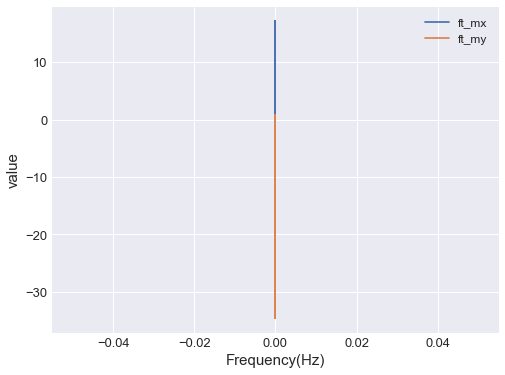

In [7]:
new_table.imag.mpl(y=['ft_mx', 'ft_my'])